In [1]:
from pytriqs.plot.mpl_interface import *
%matplotlib inline
from pytriqs.gf import *
import numpy as np
import math
from math import exp

/usr/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/nwentzel/opt/triqs/lib/python2.7/site-packages/pytriqs/gf/plot/plot_base.py:44: UserWarning: oplot of gf : no name provided !
  warn("oplot of gf : no name provided !")


omax 27.33192
abs (gt - gt_exact) =  [5.27449044e-07 2.20732486e-07 9.92740639e-08 5.37616448e-08
 3.30353639e-08]
2002


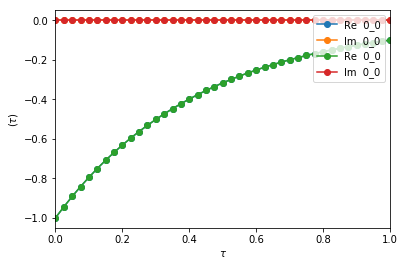

In [2]:
n_iw = 1000
beta = 50
pol = 2.3
def analy(n):
    return (pol)**(n) 

gw = GfImFreq(indices = [1], beta = beta, n_points = n_iw)
gw << inverse(iOmega_n - pol) #SemiCircular(half_bandwidth = 1)

omax = (2*n_iw + 1)*3.1416/beta/(2*pol)
print "omax", omax

gt = GfImTime(indices = [1], beta = beta, n_points = 2*n_iw + 2)
gt << InverseFourier(gw)

# EXACT
gt_ex = gt.copy()
for t in gt.mesh:
    gt_ex[t] = - exp (-pol * t)/(1  + exp (-beta * pol))

print "abs (gt - gt_exact) = ", abs((gt - gt_ex).data[0:5,0,0])

plt.xlim(0,1)
print len(gt.mesh)
oplot(gt, '-o')
oplot(gt_ex, '-o')

Diff Data:  [2.28777081e-08 2.28330123e-08 2.27884883e-08 2.27441377e-08
 2.26999550e-08 2.26559445e-08]
n                  tail                 tail2
0                -2.22e-16               7.43e-08 
1                1               1 
2                2.3               2.302 
3                5.29               4.564 
4                12.17               42.42 


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


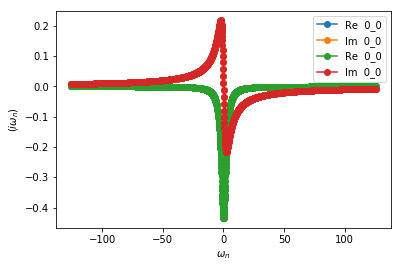

In [3]:
gw2 = gw.copy()
gw2 <<  Fourier(gt, analy(1), analy(2))

#plt.xlim(0,1)
oplot(gw, '-o')
oplot(gw2, '-o')
print 'Diff Data: ', abs((gw - gw2).data[0:6,0,0])

tail, err = gw.fit_tail()
tail2, err2 = gw2.fit_tail()

print "n                  tail                 tail2"
for n in range(5):
    print "%s                %.4g               %.4g "%(n, tail[n,0,0], tail2[n,0,0])

Fit the tail for $G(\tau)$
==================

Illustrate the idea with the expansion around 0.

`NB : we need to also add the term at beta, except it is very small in this example.`

If $\tau_i$ are the points of the grid, with $\tau_m = m \beta/N$ with $N$ points, 
and we note $\epsilon = \beta/N$ : 

$$d_m \equiv \frac{g(\tau_m) - g(0)}{\tau_m} = \sum_{j=1}^p g^{(j)}(0) \dfrac{\tau_m^{j-1}}{j!} + O(\epsilon^p)= \sum_{j=1}^p g^{(j)}(0) \, m^{j-1} \dfrac{\epsilon^{j-1}}{j!} + O(\epsilon^p)$$

So if we consider the first M points of the grid, we would like to find the least square solution to

$$\displaystyle \begin{pmatrix} d_1 \\ \ldots \\d_M\end{pmatrix}  = V * \operatorname{diag} \left(1, \ldots, \dfrac{\epsilon^{p-1}}{p!} \right) * \begin{pmatrix} g^{(1)}(0) \\ \ldots \\ g^{(p)}(0) \end{pmatrix}$$
where $V$ is the $M \times p$ Vandermonde matrix
$$ V_{m,j}= m^{j-1}$$

In [4]:
from numpy.linalg import lstsq

beta = 50.
gt2 = GfImTime(indices = [1], beta = beta, n_points = 100000)
for t in gt2.mesh:
    gt2[t] = - exp (-pol * t)/(1  + exp (-beta * pol))

energy = 0.5

# Add random noise
sig = 0.0
gt2.data[:,0,0]  += np.random.normal(0,sig, gt2.data.shape[0])

eps = list(gt2.mesh)[1].value
print "eps = ", eps

p = 8
p_range = range(1,p+1) 

M = p # int(energy / eps)
fit_indices = range(1,M+1)
dcol = np.array([(gt2.data[n,0,0] - gt2.data[0,0,0])/(n*eps) for n in fit_indices])

V = np.vander(fit_indices, p, increasing=True)
Diag = np.diag([eps**(j-1)/math.factorial(j) for j in p_range])
Gder = lstsq(np.dot(V,Diag), dcol, rcond=None)[0]

moments = [ x*(-1)**i for i,x in enumerate(Gder)]

for i in range(min(5, p)):
    print i, moments[i].real, analy(i+1), abs(1- moments[i]/analy(i+1))

eps =  0.00050000500005
0 2.300000000000059 2.3 2.5757174171303632e-14
1 5.2900000000576055 5.29 1.088973355933831e-11
2 12.166999914738296 12.167 7.007619040599877e-09
3 27.983822563791893 27.9841 9.914065776439607e-06
4 64.05062223448549 64.36343 0.004860023238576483


In [5]:
print np.linalg.inv(np.dot(V,Diag))

[[ 8.00000000e+00 -2.80000000e+01  5.60000000e+01 -7.00000000e+01
   5.60000000e+01 -2.80000000e+01  8.00000000e+00 -1.00000000e+00]
 [-5.49708789e+04  2.48397516e+05 -5.34127992e+05  6.90993090e+05
  -5.63994360e+05  2.85730476e+05 -8.23991760e+04  1.03713249e+04]
 [ 2.32662013e+08 -1.22350886e+09  2.86914262e+09 -3.88525563e+09
   3.26060145e+09 -1.68296634e+09  4.91856829e+08 -6.25320827e+07]
 [-7.01845611e+11  4.07694436e+12 -1.02908913e+13  1.46568936e+13
  -1.27249516e+13  6.72699819e+12 -2.00100664e+12  2.57858931e+11]
 [ 1.53327200e+15 -9.54628481e+15  2.55589776e+16 -3.81851392e+16
   3.44119568e+16 -1.87192512e+16  5.69310560e+15 -7.46636800e+14]
 [-2.33588320e+18  1.52952352e+19 -4.29098544e+19  6.68766561e+19
  -6.25568721e+19  3.51342432e+19 -1.09754512e+19  1.47192640e+18]
 [ 2.23986560e+21 -1.52310861e+22  4.43493389e+22 -7.16756993e+22
   6.94358337e+22 -4.03175809e+22  1.29912205e+22 -1.79189248e+21]
 [-1.02392832e+24  7.16749826e+24 -2.15024948e+25  3.58374913e+25
  -

Diff Data:  [2.28777081e-08 2.28330123e-08 2.27884883e-08 2.27441377e-08
 2.26999550e-08 2.26559445e-08]
n                  tail                 tail2
0                -2.220446e-16             7.4296479e-08 
1                1             0.99997992 
2                2.3             2.3021132 
3                5.29             4.5642003 
4                12.167             42.419593 


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


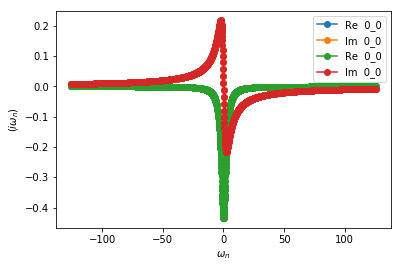

In [6]:
gt2 = gt.copy()
gt2.data[:,0,0]  += np.random.normal(0,sig, gt2.data.shape[0])

gw2 = gw.copy()
#gw2 <<  Fourier(gt2, moments[0], moments[1])
#gw2 <<  Fourier(gt, 2.28, 5.25)
#gw2 <<  Fourier(gt, analy(1), analy(2))
#gw2 <<  Fourier(gt, analy(1))
gw2 <<  Fourier(gt)

#plt.xlim(0,1)
oplot(gw, '-o')
oplot(gw2, '-o')
print 'Diff Data: ', abs((gw - gw2).data[0:6,0,0])

tail, err = gw.fit_tail()
tail2, err2 = gw2.fit_tail()

print "n                  tail                 tail2"
for n in range(5):
    print "%s                %.8g             %.8g "%(n, tail[n,0,0], tail2[n,0,0])

/usr/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


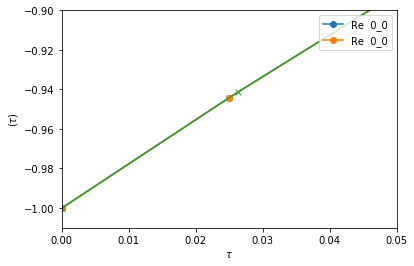

In [7]:
def f(tau):
    res = gt.data[0,0,0]
    for i, d in enumerate(Gder):
        res = res + d * tau**(i+1)/math.factorial(i+1)
    return res
        
plt.xlim(0,0.05)
plt.ylim(-1.01, -0.9)

oplotr(gt, '-o')
oplotr(gt_ex, '-o')

tau_pts = np.linspace(0,0.5,20)
plt.plot(tau_pts, [f(t) for t in tau_pts], '-x')

In [8]:
np.set_printoptions(suppress=True, precision=15)

a = np.linalg.inv(V)

f = lambda c : '{%s}'%','.join(str(x) for x in c)
f([ f(a[i,:]) for i in range(a.shape[0])])

'{{7.9999999999985585,-27.99999999998959,55.99999999997394,-69.99999999996047,55.99999999996433,-27.999999999978854,7.999999999993754,-0.9999999999992228},{-13.742857142854032,62.099999999978536,-133.53333333327762,172.74999999991633,-140.99999999992437,71.43333333329052,-20.599999999987208,2.592857142855483},{9.694444444442203,-50.98055555554068,119.54999999996016,-161.8888888888297,135.8611111110578,-70.12499999997128,20.49444444443579,-2.6055555555543912},{-3.655555555554935,21.23472222221805,-53.59999999998892,76.34027777776153,-66.27777777776346,35.03749999999251,-10.422222222219997,1.3430555555552597},{0.7986111111110731,-4.972222222221932,13.31249999999928,-19.888888888887987,17.923611111110464,-9.749999999999748,2.9652777777777213,-0.38888888888888273},{-0.10138888888890171,0.6638888888889647,-1.8625000000002185,2.902777777778144,-2.715277777778144,1.5250000000002177,-0.47638888888895914,0.06388888888889849},{0.006944444444446816,-0.04722222222223694,0.13750000000004128,-0.2222